In [1]:
import numpy as np
import matplotlib.pyplot as plt

import experiment

In [2]:
N, M = 100, 100
OUT, IN = 50, 50

exps = []

В экспериментах f и h -- кв. формы, а G -- билинейная форма.

In [3]:
exp0, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 4, 'mu': 2},
        {'min': -1, 'max': 1},
        {'L': 6, 'mu': 3},
        1111
    )
exps.append(exp0)
exp0.constants()

{'L_f': 4.000000000000018,
 'L_G': 11.469262626149439,
 'L_h': 6.0000000000000036,
 'mu_x': 1.9999999999999996,
 'mu_y': 2.9999999999999933}

In [4]:
exp1, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 8, 'mu': 4},
        {'min': -1, 'max': 1},
        {'L': 12, 'mu': 6},
        1111
    )
exps.append(exp1)
exp1.constants()

{'L_f': 8.000000000000014,
 'L_G': 11.469262626149439,
 'L_h': 11.999999999999998,
 'mu_x': 4.000000000000012,
 'mu_y': 5.999999999999986}

In [5]:
exp2, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 20, 'mu': 2},
        {'min': -1, 'max': 1},
        {'L': 10, 'mu': 9},
        1111
    )
exps.append(exp2)
exp2.constants()

{'L_f': 20.000000000000018,
 'L_G': 11.469262626149439,
 'L_h': 10.000000000000014,
 'mu_x': 1.9999999999999938,
 'mu_y': 9.000000000000005}

In [6]:
exp3, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 10, 'mu': 9},
        {'min': -1, 'max': 1},
        {'L': 20, 'mu': 2},
        1111
    )
exps.append(exp3)
exp3.constants()

{'L_f': 10.000000000000007,
 'L_G': 11.469262626149439,
 'L_h': 20.00000000000005,
 'mu_x': 8.999999999999945,
 'mu_y': 2.000000000000008}

In [7]:
np.random.seed(100)

x_0 = np.random.random(N)
y_0 = np.random.random(M)

In [8]:
np.sum(x_0**2),np.sum(y_0**2)

(30.678338374476013, 35.21003314343351)

In [9]:
def RunSaddle(x_0, y_0, exp, k_out=50, k_in=50, k_n=5, x_grad_stop_eps=None, y_grad_stop_eps=None):
    c = exp.constants()
    
    stop_callback_for_y = None
    if y_grad_stop_eps is not None:
        stop_callback_for_y = lambda grad: np.sum(grad**2) < y_grad_stop_eps**2
        
    stop_callback_for_x = None
    if x_grad_stop_eps is not None:
        stop_callback_for_x = lambda grad: np.sum(grad**2) < x_grad_stop_eps**2
    
    x, y, stats = experiment.runSaddleExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'out': {
            'H': c['L_f'] * 2.5,
            'K': k_out,
            'stop_callback': stop_callback_for_x
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y'])] * N),
            'S': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y']) + 1] * N),
            'stop_callback': None
        },
        'in': {
            'H': c['L_h'] * 2.5,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([c['L_G']] * M),
            'S': np.array([c['L_G'] + 1] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


In [10]:
def RunSaddleAdaptiveEps(x_0, y_0, exp, k_out=50, k_in=50, k_n=5, eps_start=10**-4, eps_alpha=0.9998):
    c = exp.constants()

    def stop_callback_for_y(grad):
        stop_callback_for_y.eps = eps_start
        stop_callback_for_y.eps *= eps_alpha
        return np.sum(grad**2) < stop_callback_for_y.eps**2
    
    x, y, stats = experiment.runSaddleExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'out': {
            'H': c['L_f'] * 2.5,
            'K': k_out,
            'stop_callback': None
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y'])] * N),
            'S': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y']) + 1] * N),
            'stop_callback': None
        },
        'in': {
            'H': c['L_h'] * 2.5,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([c['L_G']] * M),
            'S': np.array([c['L_G'] + 1] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


In [11]:
def RunSaddleCatalist(x_0, y_0, exp, k_catalist, mu_mult, k_out=50, k_in=50, k_n=5, x_grad_stop_eps=None, y_grad_stop_eps=None):
    c = exp.constants()
    
    stop_callback_for_y = None
    if y_grad_stop_eps is not None:
        stop_callback_for_y = lambda grad: np.sum(grad**2) < y_grad_stop_eps**2
        
    stop_callback_for_x = None
    if x_grad_stop_eps is not None:
        stop_callback_for_x = lambda grad: np.sum(grad**2) < x_grad_stop_eps**2

    x, y, stats = experiment.runSaddleCatalistExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'catalist': {
            'H': c['mu_x'] * mu_mult,
            'K': k_catalist,
            'stop_callback': None
        },
        'out': {
            'H': c['L_f'] * 2.5,
            'K': k_out,
            'stop_callback': stop_callback_for_x
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y'])] * N),
            'S': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y']) + 1] * N),
            'stop_callback': None
        },
        'in': {
            'H': c['L_h'] * 2.5,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([c['L_G']] * M),
            'S': np.array([c['L_G'] + 1] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


In [12]:
calc_res = lambda exp, x, y: exp.f.func(x) + exp.G.func(x, y) - exp.h.func(y)
calc_grad_x = lambda exp, x, y: np.sqrt(np.sum((exp.f.grad(x) + exp.G.grad_x(x, y))**2))
calc_grad_y = lambda exp, x, y: np.sqrt(np.sum((exp.G.grad_y(x, y) - exp.h.grad(y))**2))

In [13]:
res_simple_40 = []
res_simple_10 = []
res_simple_eps = []
res_catalist_10 = []
res_catalist_5 = []
res_catalist_eps = []

In [14]:
res_simple_40 = []
res_simple_10 = []
res_catalist_10 = []
res_catalist_5 = []
for i, exp in enumerate(exps):
    print('Experiment {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 100, 40, 5)
    print('Simple (100, 40): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_40.append(stat)
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 400, 10, 5)
    print('Simple (400, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_10.append(stat)
    
    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 10, 5, 40, 10, 5)
    print('Catalist (40, 10, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_10.append(stat)
    
    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 5, 5, 80, 10, 5)
    print('Catalist (5, 80, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_5.append(stat)
    
    print()

Experiment 0. params={'L_f': 4.000000000000018, 'L_G': 11.469262626149439, 'L_h': 6.0000000000000036, 'mu_x': 1.9999999999999996, 'mu_y': 2.9999999999999933}
CPU times: user 22.7 s, sys: 29.9 ms, total: 22.7 s
Wall time: 22.7 s
Simple (100, 40): f(x, y)=0.0011048299994676522
||f'_x(x_0, y_0)||=38.53005172373099 ||f'_x(x, y)||=0.14161110412555364
||f'_y(x_0, y_0)||=41.829606366063395 ||f'_y(x, y)||=1.3603781984056932e-05
CPU times: user 24.9 s, sys: 55.8 ms, total: 24.9 s
Wall time: 25 s
Simple (400, 10): f(x, y)=7.575298191374138e-06
||f'_x(x_0, y_0)||=38.53005172373099 ||f'_x(x, y)||=0.009954235590091598
||f'_y(x_0, y_0)||=41.829606366063395 ||f'_y(x, y)||=2.972126723271602e-06
CPU times: user 22.5 s, sys: 0 ns, total: 22.5 s
Wall time: 22.5 s
Catalist (40, 10, 10): f(x, y)=0.00048164094867908557
||f'_x(x_0, y_0)||=38.53005172373099 ||f'_x(x, y)||=0.1020531990197819
||f'_y(x_0, y_0)||=41.829606366063395 ||f'_y(x, y)||=9.193172779838527e-06
CPU times: user 23.7 s, sys: 36 ms, total: 23

In [15]:
res_simple_eps = []
for i, exp in enumerate(exps):
    print('Experiment {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 400, 20, 5, None, 1e-4)
    print('Simple EPS=1e-4: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_eps.append(stat)

Experiment 0. params={'L_f': 4.000000000000018, 'L_G': 11.469262626149439, 'L_h': 6.0000000000000036, 'mu_x': 1.9999999999999996, 'mu_y': 2.9999999999999933}
CPU times: user 20.5 s, sys: 24 ms, total: 20.6 s
Wall time: 20.5 s
Simple EPS=1e-4: f(x, y)=8.788819655343923e-06
||f'_x(x_0, y_0)||=38.53005172373099 ||f'_x(x, y)||=0.01193073655204304
||f'_y(x_0, y_0)||=41.829606366063395 ||f'_y(x, y)||=8.45819127277055e-05
Experiment 1. params={'L_f': 8.000000000000014, 'L_G': 11.469262626149439, 'L_h': 11.999999999999998, 'mu_x': 4.000000000000012, 'mu_y': 5.999999999999986}
CPU times: user 23.8 s, sys: 8 ms, total: 23.8 s
Wall time: 23.8 s
Simple EPS=1e-4: f(x, y)=1.0159314223492887e-05
||f'_x(x_0, y_0)||=50.31171596721387 ||f'_x(x, y)||=0.012652868982112438
||f'_y(x_0, y_0)||=63.11151804010525 ||f'_y(x, y)||=8.106509418276202e-05
Experiment 2. params={'L_f': 20.000000000000018, 'L_G': 11.469262626149439, 'L_h': 10.000000000000014, 'mu_x': 1.9999999999999938, 'mu_y': 9.000000000000005}
CPU t

In [34]:
res_simple_adaptive_eps = []
res_simple_adaptive_eps_fast = []

for i, exp in enumerate(exps):
    print('Experiment {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddleAdaptiveEps(x_0, y_0, exp, 400, 20, 5, 1e-4, 0.999)
    print('Simple Adaptive EPS=1e-4 alpha=0.9999: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_adaptive_eps.append(stat)
    
    #%time x, y, stat = RunSaddleAdaptiveEps(x_0, y_0, exp, 400, 20, 5, 1e-3, 0.9995)
    #print('Simple Adaptive EPS=1e-3 alpha=0.9999: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    #res_simple_adaptive_eps_fast.append(stat)
    
    print()

Experiment 0. params={'L_f': 4.000000000000018, 'L_G': 11.469262626149439, 'L_h': 6.0000000000000036, 'mu_x': 1.9999999999999996, 'mu_y': 2.9999999999999933}
CPU times: user 20.9 s, sys: 0 ns, total: 20.9 s
Wall time: 20.9 s
Simple Adaptive EPS=1e-4 alpha=0.9999: f(x, y)=9.702278504600334e-06
||f'_x(x_0, y_0)||=38.53005172373099 ||f'_x(x, y)||=0.012675951069830545
||f'_y(x_0, y_0)||=41.829606366063395 ||f'_y(x, y)||=7.961873588251219e-05

Experiment 1. params={'L_f': 8.000000000000014, 'L_G': 11.469262626149439, 'L_h': 11.999999999999998, 'mu_x': 4.000000000000012, 'mu_y': 5.999999999999986}
CPU times: user 27 s, sys: 16 ms, total: 27 s
Wall time: 27 s
Simple Adaptive EPS=1e-4 alpha=0.9999: f(x, y)=1.0477615577960816e-05
||f'_x(x_0, y_0)||=50.31171596721387 ||f'_x(x, y)||=0.012881364118121694
||f'_y(x_0, y_0)||=63.11151804010525 ||f'_y(x, y)||=9.647507284934418e-05

Experiment 2. params={'L_f': 20.000000000000018, 'L_G': 11.469262626149439, 'L_h': 10.000000000000014, 'mu_x': 1.99999999

In [17]:
res_catalist_eps = []
for i, exp in enumerate(exps):
    print('Experiment {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 5, 5, 80, 25, 5, 1e-4, 1e-4)
    print('Catalist EPS=1e-4: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_eps.append(stat)

Experiment 0. params={'L_f': 4.000000000000018, 'L_G': 11.469262626149439, 'L_h': 6.0000000000000036, 'mu_x': 1.9999999999999996, 'mu_y': 2.9999999999999933}
CPU times: user 39.4 s, sys: 32 ms, total: 39.4 s
Wall time: 39.4 s
Catalist EPS=1e-4: f(x, y)=0.0001495234682722504
||f'_x(x_0, y_0)||=38.53005172373099 ||f'_x(x, y)||=0.05488507003980063
||f'_y(x_0, y_0)||=41.829606366063395 ||f'_y(x, y)||=9.233987285001775e-05
Experiment 1. params={'L_f': 8.000000000000014, 'L_G': 11.469262626149439, 'L_h': 11.999999999999998, 'mu_x': 4.000000000000012, 'mu_y': 5.999999999999986}
CPU times: user 45.2 s, sys: 72 ms, total: 45.3 s
Wall time: 45.3 s
Catalist EPS=1e-4: f(x, y)=0.0002590507754706359
||f'_x(x_0, y_0)||=50.31171596721387 ||f'_x(x, y)||=0.0700197483305443
||f'_y(x_0, y_0)||=63.11151804010525 ||f'_y(x, y)||=8.166514210599181e-05
Experiment 2. params={'L_f': 20.000000000000018, 'L_G': 11.469262626149439, 'L_h': 10.000000000000014, 'mu_x': 1.9999999999999938, 'mu_y': 9.000000000000005}
CP

**Зависимость найденного значения от кол-ва вызовов оракулов $\nabla f$ и $\nabla h$**

In [18]:
def collectFfromfOracleSimple(stats):
    return stats['out_stats']['fs']

def collectFfromhOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r += st['fs']
    return r

def collectFfromfOracleCatalist(stats):
    r = []
    for st in stats['saddle']:
        r += collectFfromfOracleSimple(st)
    return r

def collectFfromhOracleCatalist(stats):
    r = []
    for st in stats['saddle']:
        r += collectFfromhOracleSimple(st)
    return r

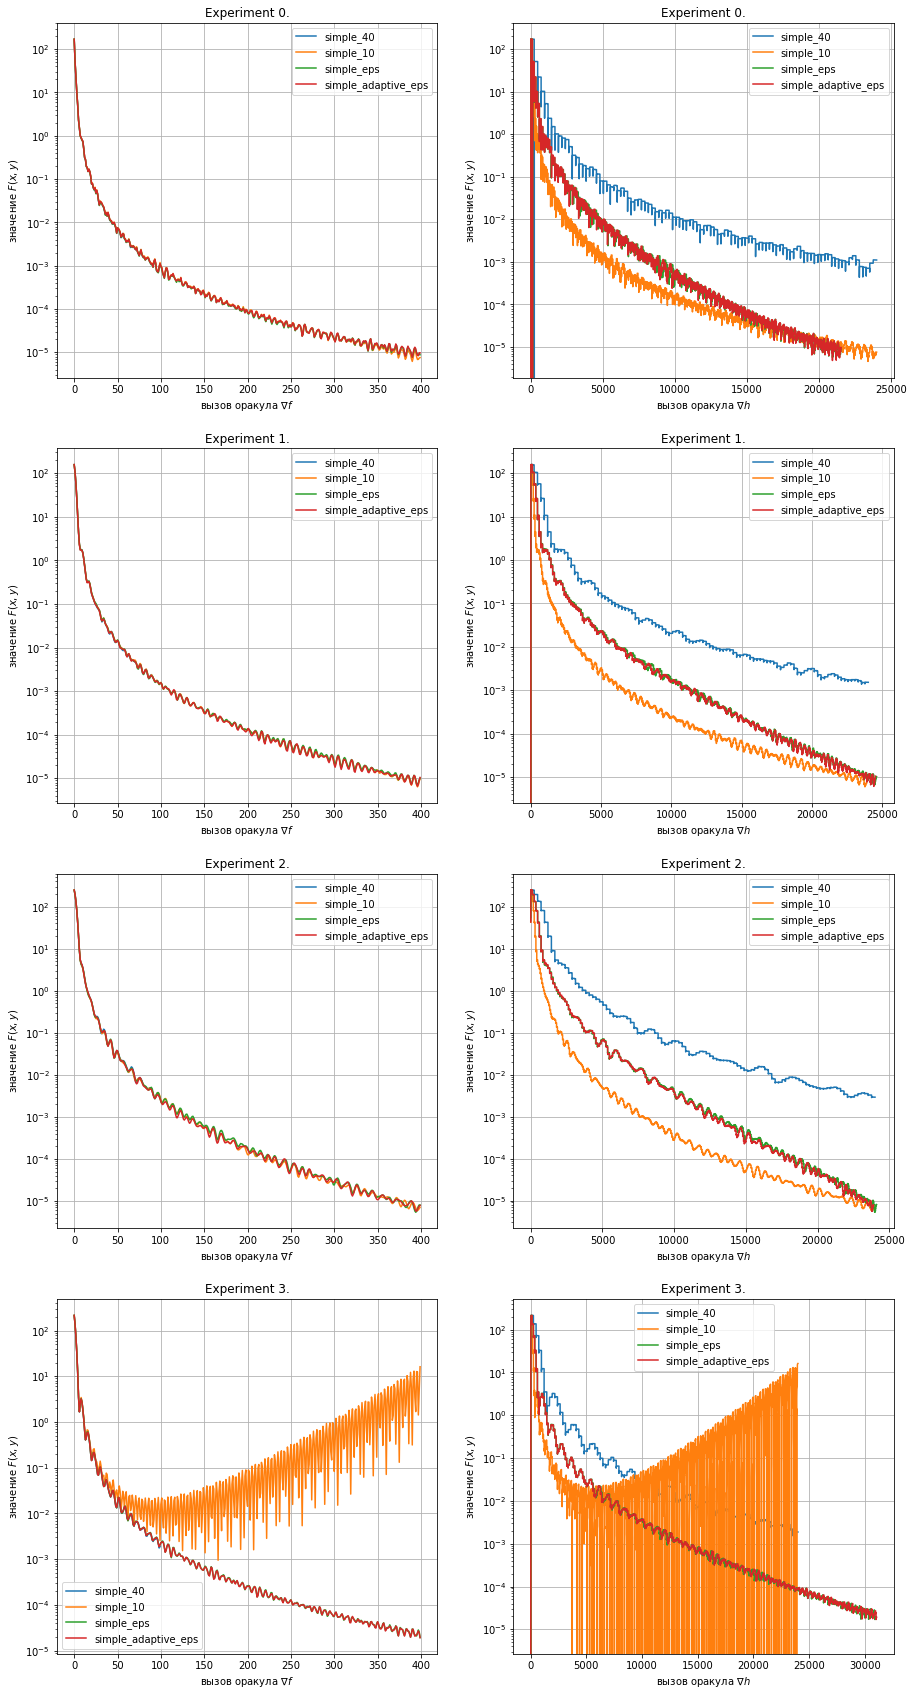

In [35]:
plt.figure(figsize=(15,30))

for i in range(len(exps)):
    ax = plt.subplot(4, 2, 1 + i * 2)
    ax.set_title('Experiment {}.'.format(i))
    
    Ff = collectFfromfOracleSimple(res_simple_40[i])
    ax.plot(range(len(Ff)), Ff, label='simple_40')
    
    Ff = collectFfromfOracleSimple(res_simple_10[i])
    ax.plot(range(len(Ff)), Ff, label='simple_10')

    Ff = collectFfromfOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Ff)), Ff, label='simple_eps')
    
    Ff = collectFfromfOracleSimple(res_simple_adaptive_eps[i])
    ax.plot(range(len(Ff)), Ff, label='simple_adaptive_eps')
    
    #Ff = collectFfromfOracleSimple(res_simple_adaptive_eps_fast[i])
    #ax.plot(range(len(Ff)), Ff, label='simple_adaptive_eps_fast')
        
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(4, 2, 1 + i * 2 + 1)
    ax.set_title('Experiment {}.'.format(i))
    
    Fh = collectFfromhOracleSimple(res_simple_40[i])
    ax.plot(range(len(Fh)), Fh, label='simple_40')

    Fh = collectFfromhOracleSimple(res_simple_10[i])
    ax.plot(range(len(Fh)), Fh, label='simple_10')
    
    Fh = collectFfromhOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Fh)), Fh, label='simple_eps')
    
    Fh = collectFfromhOracleSimple(res_simple_adaptive_eps[i])
    ax.plot(range(len(Fh)), Fh, label='simple_adaptive_eps')
    
    #Fh = collectFfromhOracleSimple(res_simple_adaptive_eps_fast[i])
    #ax.plot(range(len(Fh)), Fh, label='simple_adaptive_eps_fast')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    

**Выводы**

simple_*, catalist_* имеют фиксированное число итераций для обоих метаалгоритмов.
simple_stop, catalist_stop имеют проверку

Видно, что первые два эксперимента довольно похожи, хотя $L$ и $\mu$ в них отличаются в 2 раза. Это подтверждает то, что скорость сходимоти зависит от частного величин, а не от них самих. Хотя метод, делающий больше итераций для $x$, сходится быстрее. Это потому, что в данном примере поиск максимума по $y$ для нахождения градиента $g$ запоминает прошлый найденный $y$ и использует его в следующем вызове в качестве стартового значения. Из-за этого внутренний метаалгоритм сходится быстрее.

Из экспериментов 2 и 3 для simple_10 и simple_40 видно, что лучше сходится алгоритм, который делает большее число итераций по тем компонентам (из $x$ и $y$), где число обусловленности $\frac{L}{\mu}$ больше. Это полностью согласуется с теоретическими выводами в статье https://arxiv.org/pdf/2004.08691.pdf (для сходимости для $f$ требуется $O(\sqrt{\frac{L_f}{\mu_x}})$ шагов, а для $h$ -- $O(\sqrt{\frac{L_h}{\mu_y}})$ шагов)
TODO: исследовать зависимость подробнее на одной-двух функциях

Можно заметить, что график метода с остановкой по $\varepsilon$ во всех случаях лучший или очень близок к лучшему методу по сходимости по вызовам $\nabla f$, однако он не лучший сходимости по вызовам $\nabla h$. Это потому, что вначале происходят большие шаги по $x$, соответственно по $y$ для нахождения хорошего приближения требуется сделать больше шагов.

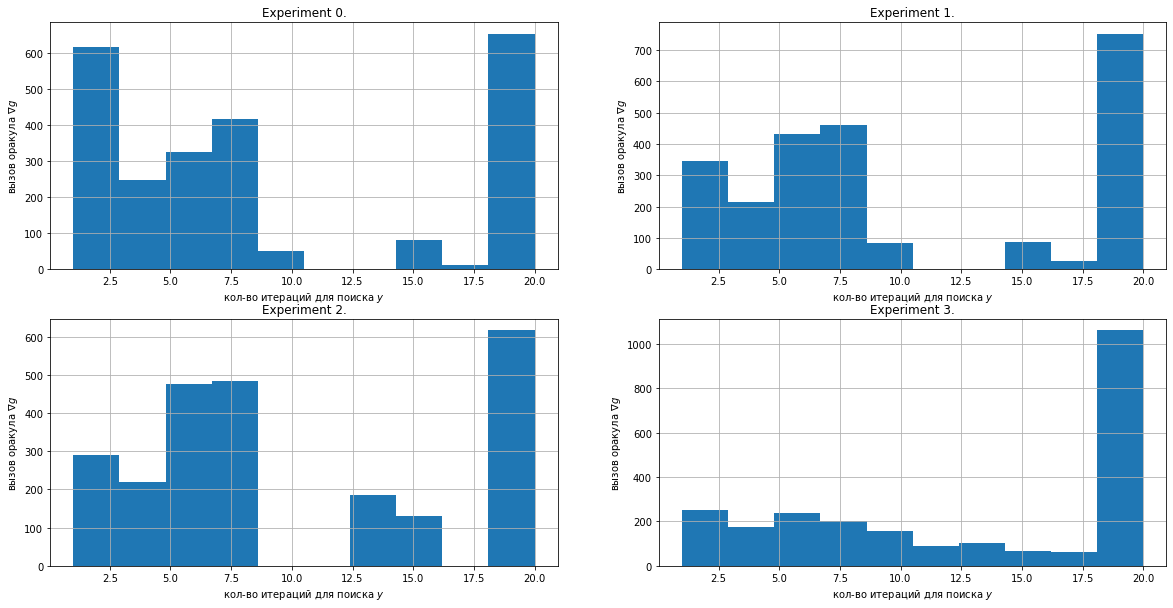

In [20]:
def collectItersBygOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r.append(st['iters'])
    return r


plt.figure(figsize=(20,10))
for i in range(len(exps)):
    ax = plt.subplot(2, 2, 1 + i)
    ax.set_title('Experiment {}.'.format(i))
    
    ItersByg = collectItersBygOracleSimple(res_simple_eps[i])
    
    #ax.plot(range(len(ItersByg)), ItersByg)
    ax.hist(ItersByg)
    
    plt.ylabel('вызов оракула $\\nabla g$')
    plt.xlabel('кол-во итераций для поиска $y$')
    plt.grid(True)
    #plt.legend()

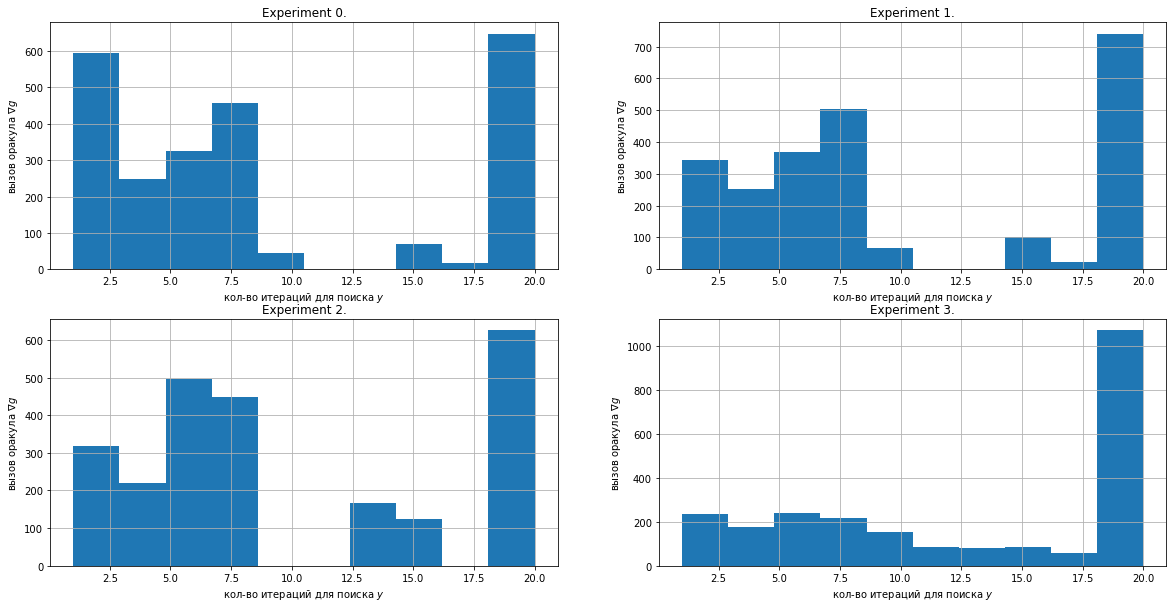

In [36]:
def collectItersBygOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r.append(st['iters'])
    return r


plt.figure(figsize=(20,10))
for i in range(len(exps)):
    ax = plt.subplot(2, 2, 1 + i)
    ax.set_title('Experiment {}.'.format(i))
    
    ItersByg = collectItersBygOracleSimple(res_simple_adaptive_eps[i])
    
    #ax.plot(range(len(ItersByg)), ItersByg)
    ax.hist(ItersByg)
    
    plt.ylabel('вызов оракула $\\nabla g$')
    plt.xlabel('кол-во итераций для поиска $y$')
    plt.grid(True)
    #plt.legend()

**Вывод**
Как видно при использовании остановки по $\varepsilon$ часто делается мало итераций, однако в большинстве случаев делаются все доступные итерации, т.е. заметного выигрыша по количеству итераций по сравнению с другими методами не получается.

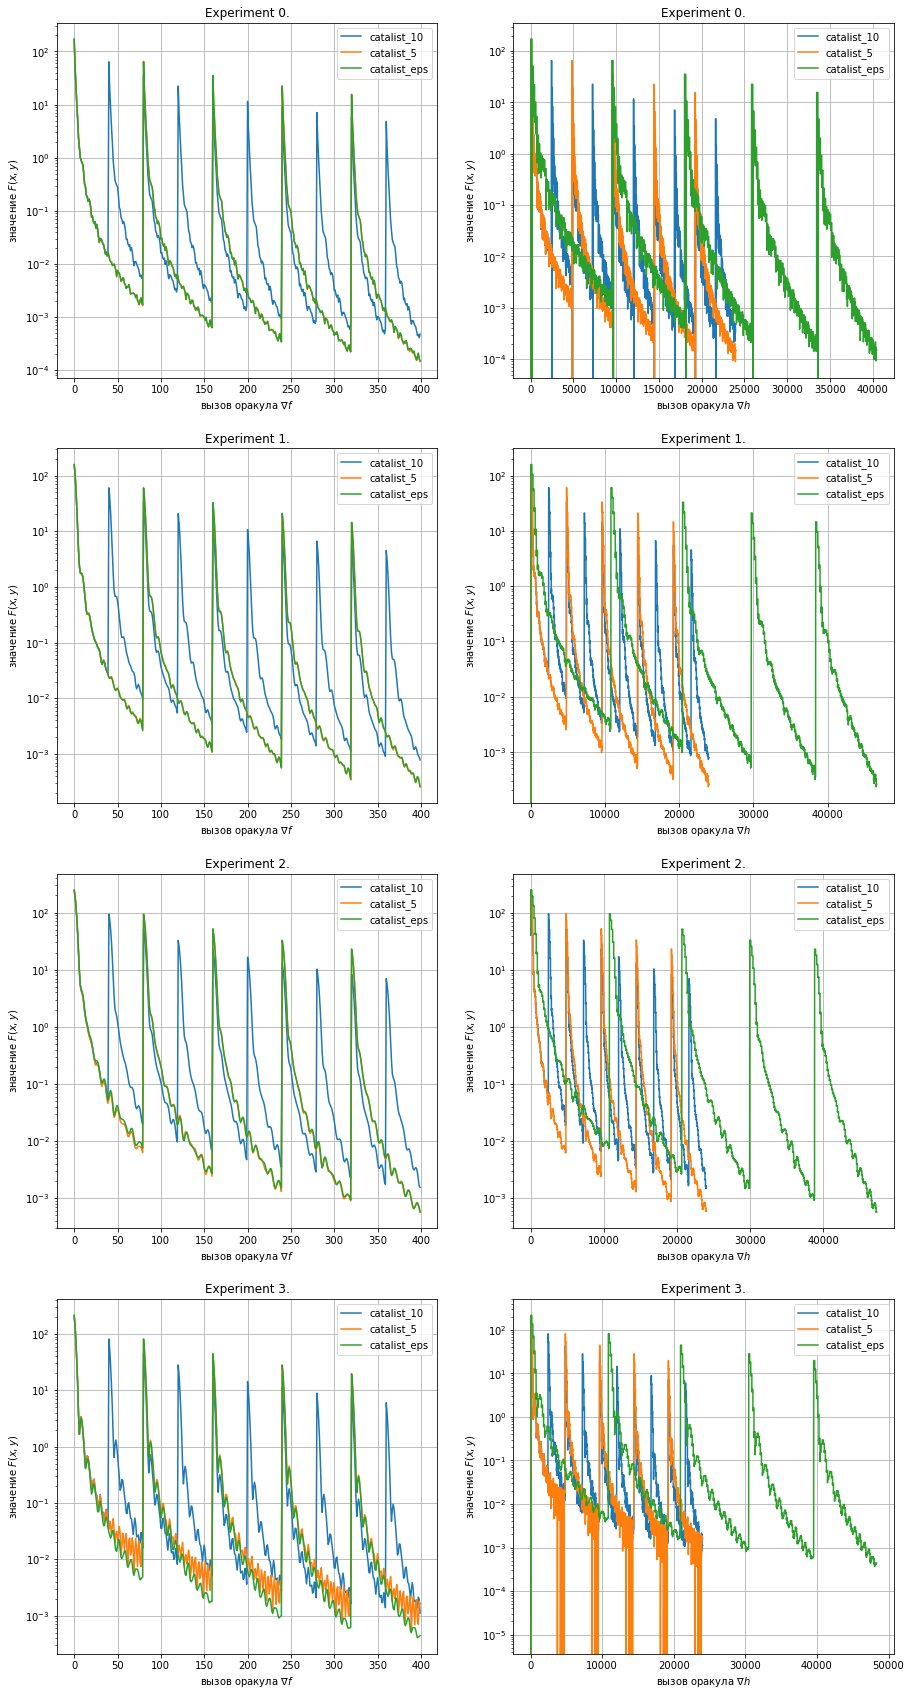

In [22]:
plt.figure(figsize=(15,30))

for i in range(len(exps)):
    ax = plt.subplot(4, 2, 1 + i * 2)
    ax.set_title('Experiment {}.'.format(i))

    Ff = collectFfromfOracleCatalist(res_catalist_10[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_10')
    
    Ff = collectFfromfOracleCatalist(res_catalist_5[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_5')
    
    Ff = collectFfromfOracleCatalist(res_catalist_eps[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_eps')
        
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(4, 2, 1 + i * 2 + 1)
    ax.set_title('Experiment {}.'.format(i))
    
    Fh = collectFfromhOracleCatalist(res_catalist_10[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_10')
    
    Fh = collectFfromhOracleCatalist(res_catalist_5[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_5')
    
    Fh = collectFfromhOracleCatalist(res_catalist_eps[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_eps')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    

**Выводы**

simple_*, catalist_* имеют фиксированное число итераций для обоих метаалгоритмов.
simple_stop, catalist_stop имеют проверку


Видно, что каталист в данном случае сходится плохо из-за того, что на каждой итерации из-за шага во внешнем цикле (по x) его отбрасывает в большие значений функции. Однако в эксперименте 3, где $\mu_x$ большое, он сходится в лучшему ответу, чем алгортмы simple_* , причем это применимо к обоим вариантам запуска каталист.

Из-за плохой сходимости catalist_eps не успевает за отведенное число итераций достигнуть точки, в которой произойдет остановка.
